In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, asc, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
m = Base.classes.measurement
s = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector object on database
inspector = inspect(engine)

# Check columns in m table
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'], c['type'])
    
print('\n')

# Check columns in s table
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

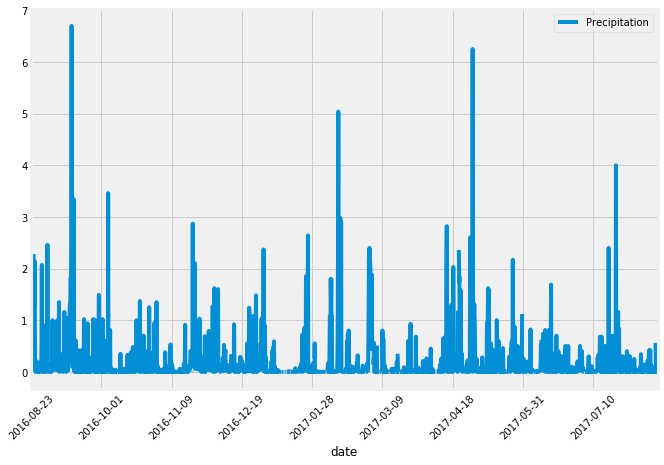

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(m.date).order_by(m.date.desc()).first()
last_date = date.fromisoformat(last_date[0])
year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# Sort by date
date_prcp = session.query(m.date, m.prcp).filter(m.date >= year_ago).order_by(m.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp)
date_prcp_df = date_prcp_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
ax = date_prcp_df.prcp.plot(rot = 45, figsize = (10,7))
ax.legend(['Precipitation'])

![precipitation](Images/precipitation.png)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [31]:
# Design a query to show how many stations are available in this dataset?
st_count = session.query(s).group_by(s.station).count()
print(f'There are {st_count} stations.')

There are 9 stations.


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

st_count = session.query(m.station, func.count(m.station)).group_by(m.station).order_by(func.count(m.station).desc())

for i in st_count:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_st = st_count.first()
top_st = top_st[0]

session.query(func.min(m.tobs), func.max(m.tobs), func.avg(m.tobs)).filter(m.station == top_st).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperature Histogram\nTop Station (USC00519281)')

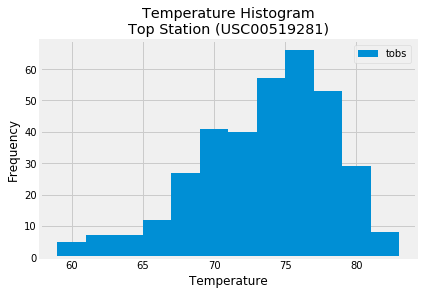

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(m.tobs).filter(m.date >= year_ago).filter(m.date <= last_date).filter(m.station == top_st).all()
temps = [temp for i in temps for temp in i]
plt.hist(temps, bins=12)
plt.legend(['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Histogram\nTop Station ({top_st})')

![precipitation](Images/station-histogram.png)

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(m.tobs), func.avg(m.tobs), func.max(m.tobs)).\
        filter(m.date >= start_date).filter(m.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
atrip = calc_temps('2017-07-01', '2017-07-07')
trip_df = pd.DataFrame(atrip, columns=['min', 'avg', 'max'])
trip_df.head()
atrip = atrip[0]
errors = atrip[2]-atrip[0]

Text(0, 0.5, 'Temp (°F)')

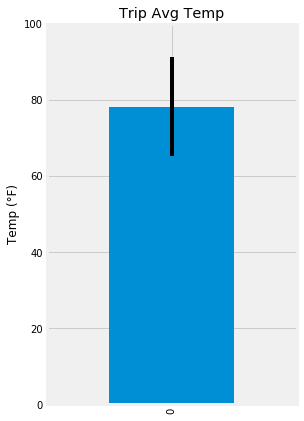

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ax = trip_df.plot(kind='bar', y='avg', yerr = errors, figsize = (4,7), ylim = [0, 100], title = 'Trip Avg Temp', legend = False)
ax.set_ylabel('Temp (°F)')


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
